In [31]:
import pandas as pd
from umap import UMAP
import re
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_short
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import preprocess_string
from sklearn.metrics import precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from typing import Callable

# %mathplotlib inline

In [32]:
df_rc = pd.read_csv('./csv/Reddit_Combi.csv', sep=';')
df_rc = df_rc.assign(text=(df_rc['title'] + ' | ' + df_rc['body']).str.lower())[['text', 'label']]
df_rc['text'] = df_rc['text'].astype(str)
df_rc['label'] = df_rc['label'].astype('int')
df_rc

,text,label
0,envy to other is swallowing me | im from devel...,1
1,nothin outta the ordinary. paradise. job stres...,1
2,almost 49 and the chasm of emptiness has never...,1
3,i’m happy again | after my closest friend left...,0
4,is it possible to recover from such a traumati...,1
...,...,...
3118,"positive relief ideas with stress? | hi all, m...",1
3119,breakdown | i really think i lost my mind last...,1
3120,i feel as if i actually died a long time ago a...,1
3121,is it wierd that i have imaginary friends at t...,1


In [33]:
df_tw = pd.read_csv('./csv/Twitter_Full.csv', sep=';', usecols=['text', 'hashtags', 'labels'])
df_tw.rename(columns={'labels': 'label'}, inplace=True)
df_tw['label'] = df_tw['label'].astype('int')
df_tw['text'] = df_tw['text'].astype('str')
df_tw['hashtags'] = df_tw['hashtags'].astype('str')
df_tw['text'] =  df_tw['hashtags'].apply(lambda s: re.sub(r"[\[\]\']", "", s)) + ' | ' + df_tw['text']
df_tw.drop(columns=['hashtags'], inplace=True)
df_tw

,text,label
0,"momlife, kids, tired | Being s mom is cleaning...",1
1,walkthru | And now we have been given the walk...,0
2,"Peace, Joy, Love, JoyTrain, MentalHealth, Quot...",0
3,"therapy, help, NLP, CBT, hypnotherapy, mentalh...",1
4,| Psy Do u hv any regrets? Me No Psy Are you ...,0
...,...,...
8895,"business, business, Stress, mind, body | Thank...",0
8896,"""walkthemind"", ""walking"", ""walk"", ""hiking"", ""m...",1
8897,"m1hl, stress, technostress, tips | no mobile ...",1
8898,"DogsofTwittter, shout, getoutforshout, charity...",1


In [34]:
# Choose what data to process

# df = pd.concat([df_rc, df_tw]).reset_index()
df = df_rc
df

,text,label
0,envy to other is swallowing me | im from devel...,1
1,nothin outta the ordinary. paradise. job stres...,1
2,almost 49 and the chasm of emptiness has never...,1
3,i’m happy again | after my closest friend left...,0
4,is it possible to recover from such a traumati...,1
...,...,...
3118,"positive relief ideas with stress? | hi all, m...",1
3119,breakdown | i really think i lost my mind last...,1
3120,i feel as if i actually died a long time ago a...,1
3121,is it wierd that i have imaginary friends at t...,1


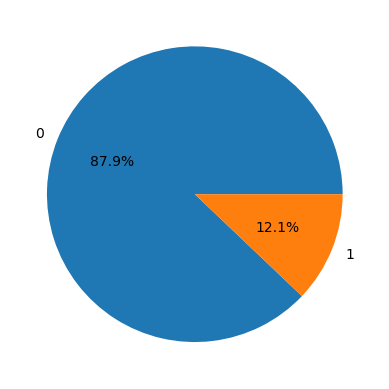

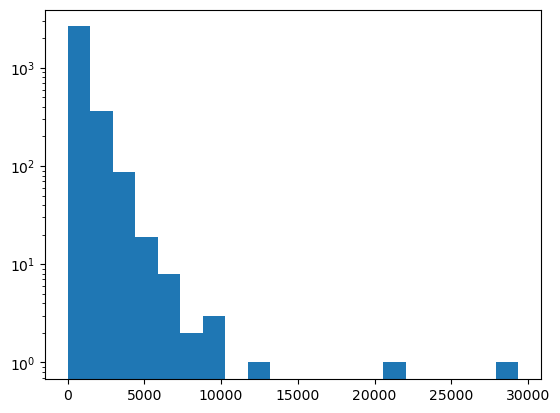

In [35]:
plt.pie(df.value_counts(subset=['label']), labels=[0,1], autopct='%1.1f%%',)
plt.show()

plt.hist([len(x) for x in df['text']], bins=20, log=True)
plt.show()

In [36]:
CUSTOM_FILTERS: list[Callable[[str], str]] = [
    lambda x: x.lower(),
    remove_stopwords,
    strip_multiple_whitespaces,
    strip_numeric,
    strip_punctuation,
    strip_short,
    strip_tags,
]

docs = df['text'].values.tolist()
texts = [preprocess_string(s=doc, filters=CUSTOM_FILTERS) for doc in docs]
dic = Dictionary(texts)
corpus = [dic.doc2bow(text) for text in texts]

print(dic)


Dictionary<14366 unique tokens: ['afford', 'age', 'beetwen', 'better', 'big']...>


In [37]:
# Vectorize texts

from arrow import now
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

time_start = now()
doc2vec_model = Doc2Vec(vector_size=8000, min_count=20, epochs=40)
corpus_iterable = [TaggedDocument(item, [index]) for index, item in enumerate(corpus) ]
doc2vec_model.build_vocab(corpus_iterable=corpus_iterable)
doc2vec_model.train(corpus_iterable=corpus_iterable, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs,)
df['vector'] = doc2vec_model.dv.vectors.tolist()
print('doc2vec training time: {}'.format(now() - time_start))


doc2vec training time: 0:00:44.517636


In [38]:
time_start = now()
umap = UMAP(n_components=2, verbose=1, init='pca', n_jobs=1)
df[['x', 'y']] = umap.fit_transform(X=df['vector'].apply(func=pd.Series))
df['short_document'] = df['text'].str[:80]
print(f'doc2vec umap time: {now() - time_start}')


UMAP(init='pca', n_jobs=1, verbose=1)
Wed Apr 24 11:42:23 2024 Construct fuzzy simplicial set
Wed Apr 24 11:42:32 2024 Finding Nearest Neighbors
Wed Apr 24 11:42:33 2024 Finished Nearest Neighbor Search
Wed Apr 24 11:42:33 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Apr 24 11:42:36 2024 Finished embedding
doc2vec umap time: 0:00:14.783223


In [39]:
def plot_scatter(x, y, c):
    _, ax = plt.subplots(figsize=(10,6))
    scatter = ax.scatter(x=x, y=y, c=c, marker='o', s=25)
    plt.colorbar(scatter, ax=ax)
    plt.show()

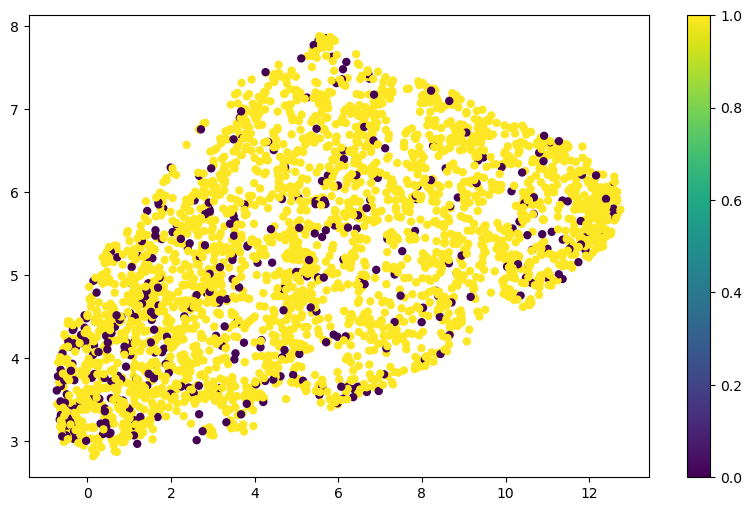

In [40]:
plot_scatter(x=df['x'], y=df['y'], c=df['label'])

In [43]:
# prepare a function to train LR, predict on test and display metrics

def train_lr(df: DataFrame, feature: str, label: str = 'label', test_size: float = 0.2) -> LogisticRegression:
    X_train, X_test, y_train, y_test = train_test_split(
        df[feature].apply(func=pd.Series),
        df[label],
        test_size=test_size,
        stratify=df[label],
    )

    time_start = now()
    lr = LogisticRegression().fit(X=X_train, y=y_train)
    print('model fit in {} iterations took {}'.format(lr.n_iter_[0], now() - time_start))

    # scores for the positive label
    y_score = lr.predict_proba(X_test)[:,1]

    # 2D PR-curve
    precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=y_score)
    print(f'auprc: {auc(recall, precision)}')
    pr = pd.DataFrame({'Recall': recall, 'Precision': precision})
    plt.figure(figsize=(10, 6))
    plt.plot(pr['Recall'], pr['Precision'])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR-curve')
    plt.show()

    # let's try predict() for binary inference
    y_pred = lr.predict(X_test)
    print(classification_report(y_true=y_test, y_pred=y_pred))

    print(f'model done in {now() - time_start}')


model fit in 62 iterations took 0:00:00.900561
auprc: 0.9566625905235783


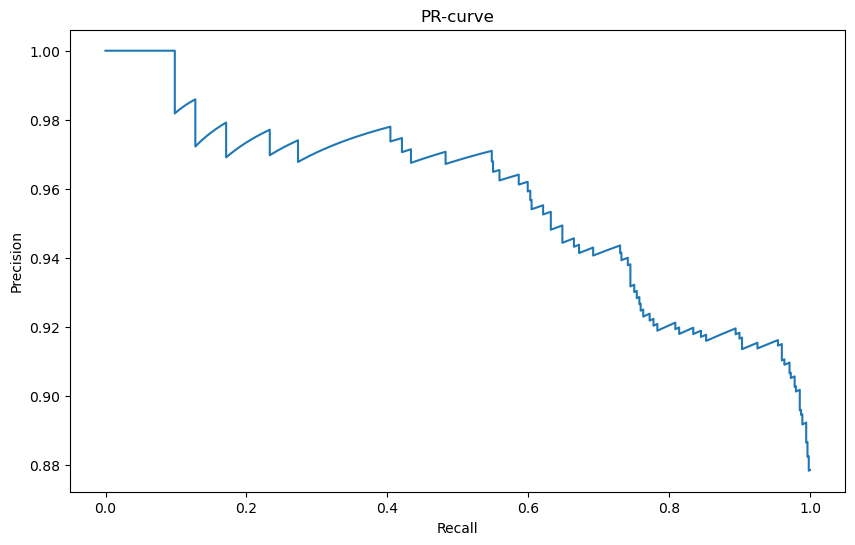

              precision    recall  f1-score   support

           0       0.67      0.08      0.14        76
           1       0.89      0.99      0.94       549

    accuracy                           0.88       625
   macro avg       0.78      0.54      0.54       625
weighted avg       0.86      0.88      0.84       625

model done in 0:00:01.121868


In [44]:
# LR on vectors
train_lr(df, 'vector')


In [45]:
from keybert import KeyBERT
from sklearn.feature_extraction.text import TfidfVectorizer

model_start = now()
bert = KeyBERT(model='all-MiniLM-L12-v2')
bert.max_seq_length = 512
vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words='english', min_df=4, max_df=1.0)
document_embeddings, word_embeddings = bert.extract_embeddings(docs=docs, vectorizer=vectorizer)

print(f'embedding time: {now() - model_start}')
print(f'we have {len(document_embeddings)} documents and {len(word_embeddings)} words.')


embedding time: 0:00:07.453264
we have 3123 documents and 4656 words.


UMAP(init='pca', n_jobs=1, verbose=1)
Wed Apr 24 11:43:59 2024 Construct fuzzy simplicial set
Wed Apr 24 11:44:01 2024 Finding Nearest Neighbors
Wed Apr 24 11:44:02 2024 Finished Nearest Neighbor Search
Wed Apr 24 11:44:02 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Apr 24 11:44:05 2024 Finished embedding


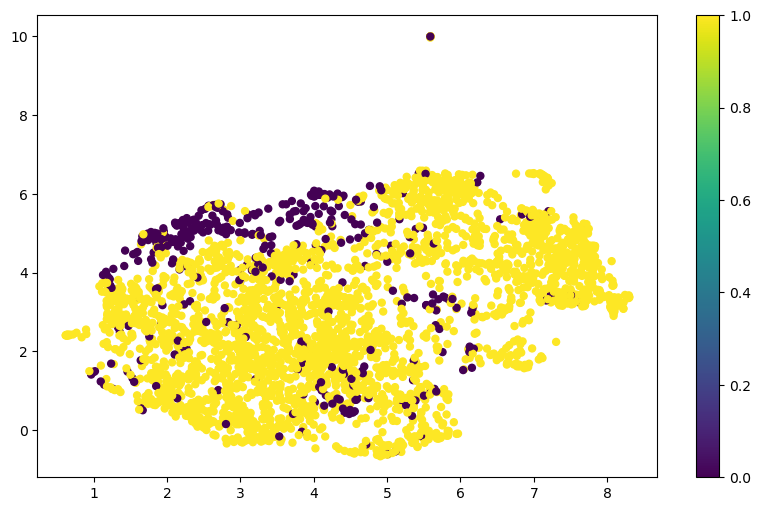

In [46]:
df['embedding'] = document_embeddings.tolist()
embedding_umap_model = UMAP(n_components=2, verbose=1, init='pca', n_jobs=1)
df[['ex', 'ey']] = embedding_umap_model.fit_transform(X=df['embedding'].apply(func=pd.Series),)
plot_scatter(x=df['ex'], y=df['ey'], c=df['label'])

model fit in 34 iterations took 0:00:00.139149
auprc: 0.9945596587770833


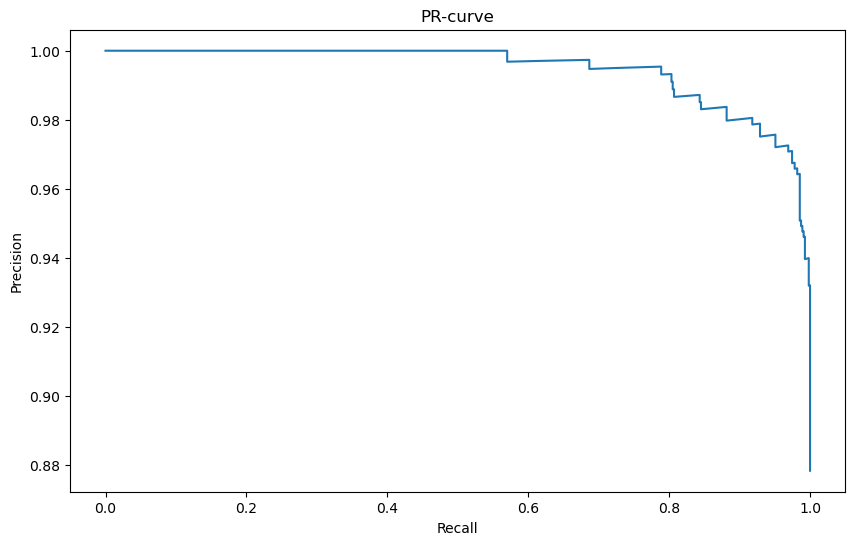

              precision    recall  f1-score   support

           0       0.91      0.57      0.70        76
           1       0.94      0.99      0.97       549

    accuracy                           0.94       625
   macro avg       0.93      0.78      0.83       625
weighted avg       0.94      0.94      0.93       625

model done in 0:00:00.242544


In [48]:
# LR on embeddings
train_lr(df, 'embedding')